# Survival Analysis

In [2]:
from awpy import Demo

# folder of demos
path = ".demos/"

# match one between Faze and Cloud 9 in the Perfect World Shanghai RMR for 4th place
# accessed via https://www.hltv.org/matches/2377025/match
match = "faze-vs-cloud-9-m1-mirage.dem"

# load demo
dem = Demo(path + match)

Things that I would like to do:
1. Build a Kaplan-Meier curve
    * Overall and by team
2. Accelerated Failure Time model
    * Find factors that extend a players time until elimination
3. Cox Proportional Hazard model
    * Find factors taht decrease risk of elimination

Factors that seem important right now:
* Guns bought
* Armor / helmet
* Economy prior to round start
* Position
* Damage taken
* Kills in the round
* Bomb status

## Kaplan Meier

Some things I need: 
* acculumated time each player was alive in a round
* key to distinguish: team name / side (T or CT)

In [159]:
rounds = dem.rounds

# creating how long a player could be alive for on a given round
rounds['round_length'] = dem.rounds['official_end'] - dem.rounds['freeze_end']
rounds['round_length_seconds'] = rounds['round_length']/64

# rounds[['round', 'round_length_seconds']]

In [ ]:
import pandas as pd
import numpy as np

kills = dem.kills

# grab victim name and ticks since round start
# this will not have everyone 
# but create list general list of every player for every round
# then if they don't have a time they will be censored
base_info = dem.events['player_team'][['user_name', 'user_team_clan_name']]

# record of when people are eliminated
death_info = kills[['victim_name', 'victim_team_name',  'round' ,'ticks_since_round_start']].rename(columns = {'victim_name':'user_name'})

# simple function to repeat the base information as many times as there are rows
def repeat_dataframe(df, n):
    return pd.concat([df] * n, ignore_index=True)

# repeat all players 19 times
blank_info = repeat_dataframe(base_info, dem.rounds.shape[0]) 

# create round for each
blank_info['round'] = np.concatenate([([i]*10) for i in range(1, 20)], axis=0) 

# set index for easy indexing
blank_info = blank_info.set_index(['round', 'user_name'])
death_info = death_info.set_index(['round', 'user_name'])

# join death information onto blank info
survival_info = blank_info.join(death_info)

# create time in seconds
survival_info['seconds'] = survival_info['ticks_since_round_start']/64

# censor information
# if there is NOT a time, then they survived and are a 0
survival_info['died'] = np.select(
    [
        survival_info['seconds'].isna()
    ],
    [
        False
    ],
    default = True
)

# kaplan meier can't deal with missing values so set them to official end
# Merge the tables on the 'round' column
merged_table = survival_info.reset_index().merge(rounds, on='round', how='left')

# Fill NA values in 'seconds' with 'round_length'
merged_table['seconds'] = merged_table['seconds'].fillna(merged_table['round_length_seconds'])

survival_data = merged_table[['round', 'user_name', 'user_team_clan_name', 'victim_team_name', 'seconds', 'died']]

Text(0.5, 0, 'time $t$')

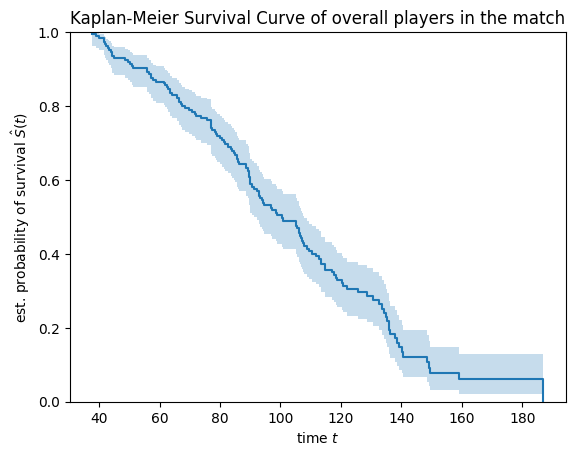

In [200]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    survival_data["died"], survival_data["seconds"], conf_type="log-log"
)

plt.title("Kaplan-Meier Survival Curve of overall players in the match")
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## Survival curve by team

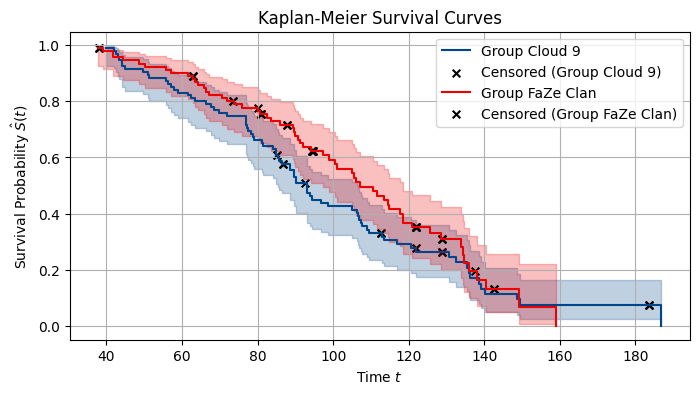

In [ ]:
plt.figure(figsize=(8, 4))

# Lancet color palette
lancet_palette = ["#00468B", "#ED0000", "#42B540", "#0099B4", "#925E9F", "#FDAF91"]


# Iterate through each group
for i, group in enumerate(survival_data['user_team_clan_name'].unique()):
    # Filter data for the group
    group_data = survival_data[survival_data['user_team_clan_name'] == group]
    
    # Compute Kaplan-Meier estimator
    time, survival_prob, conf_int = kaplan_meier_estimator(
        group_data['died'], 
        group_data['seconds'],
        conf_type="log-log"
    )
    
    # Plot the survival curve
    plt.step(time, survival_prob, where="post", label=f"Group {group}", color = lancet_palette[i % len(lancet_palette)])

    # Add confidence intervals
    plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post", color = lancet_palette[i % len(lancet_palette)])

    # Add censored points
    censored_times = group_data[group_data['died'] == False]['seconds']
    censored_survival = [survival_prob[np.searchsorted(time, t, side="right") - 1] for t in censored_times]
    plt.scatter(censored_times, censored_survival, 
                color="black", s=30, marker = "x", label=f"Censored (Group {group})")

# Customize the plot
plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Time $t$")
plt.ylabel("Survival Probability $\hat{S}(t)$")
plt.legend()
plt.grid(True)
plt.show()

## Survival curve by Team/Side playing on

In [186]:
# first need to fill in missing team side values victim side only exists when they died
survival_data['clean_team'] = np.select(
    [
        (survival_data['victim_team_name'].isna()) & (survival_data['round'] <= 12) & (survival_data['user_team_clan_name'] == "FaZe Clan"),
        (survival_data['victim_team_name'].isna()) & (survival_data['round'] >= 12) & (survival_data['user_team_clan_name'] == "FaZe Clan"),
        (survival_data['victim_team_name'].isna()) & (survival_data['round'] <= 12) & (survival_data['user_team_clan_name'] == "Cloud 9"),
        (survival_data['victim_team_name'].isna()) & (survival_data['round'] >= 12) & (survival_data['user_team_clan_name'] == "Cloud 9")    
    ],
    [
        'CT',
        'TERRORIST',
        'TERRORIST',
        'CT'
    ],
    default =  survival_data['victim_team_name']
)


# now create an indicator of team name/ side
survival_data['team_side_identifier'] = survival_data['user_team_clan_name'] + "-" + survival_data["clean_team"]

C:\Users\goldp\AppData\Local\Temp\ipykernel_32668\2377659806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_data['clean_team'] = np.select(
C:\Users\goldp\AppData\Local\Temp\ipykernel_32668\2377659806.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_data['team_side_identifier'] = survival_data['user_team_clan_name'] + "-" + survival_data["clean_team"]


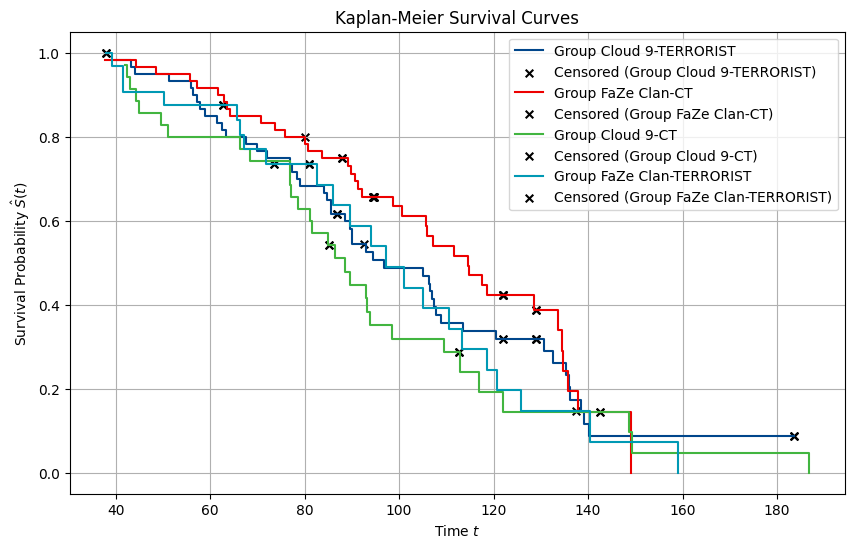

In [213]:
# now recreate Kaplan Meier curve with each team/side combo as own survival curve
# Initialize the plot
plt.figure(figsize=(10, 6))

for i, group in enumerate(survival_data['team_side_identifier'].unique()):
    # Filter data for the group
    group_data = survival_data[survival_data['team_side_identifier'] == group]
    
    # Compute Kaplan-Meier estimator
    time, survival_prob, conf_int = kaplan_meier_estimator(
        group_data['died'], 
        group_data['seconds'],
        conf_type="log-log"
    )
    
    # Plot the survival curve
    plt.step(time, survival_prob, where="post", label=f"Group {group}", color = lancet_palette[i % len(lancet_palette)])

    # Add censored points
    censored_times = group_data[group_data['died'] == False]['seconds']
    censored_survival = [survival_prob[np.searchsorted(time, t, side="right") - 1] for t in censored_times]
    plt.scatter(censored_times, censored_survival, 
                color="black", s=30, marker = "x", label=f"Censored (Group {group})")


# Customize the plot
# plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Time $t$")
plt.ylabel("Survival Probability $\hat{S}(t)$")
plt.legend()
plt.grid(True)
plt.show()

## Each team by side

### Cloud 9

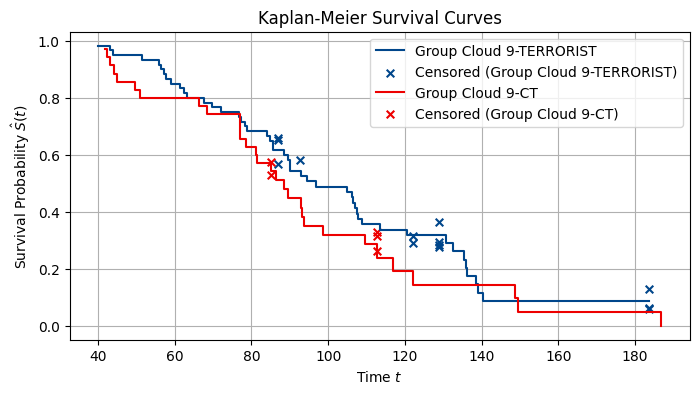

In [233]:
# make Cloud 9 survival data
c9_survival = survival_data[survival_data['user_team_clan_name'] == "Cloud 9"]

plt.figure(figsize=(8,4))

# add jitter to points to distinguish between multiple censors at one time
jitter_strength = 0.05

for i, group in enumerate(c9_survival['team_side_identifier'].unique()):
    # Filter data for the group
    group_data = c9_survival[c9_survival['team_side_identifier'] == group]
    
    # Compute Kaplan-Meier estimator
    time, survival_prob, conf_int = kaplan_meier_estimator(
        group_data['died'], 
        group_data['seconds'],
        conf_type="log-log"
    )
    
    # Plot the survival curve
    plt.step(time, survival_prob, where="post", label=f"Group {group}", color = lancet_palette[i % len(lancet_palette)])

    # Add censored points
    censored_times = group_data[group_data['died'] == False]['seconds']
    censored_survival = [survival_prob[np.searchsorted(time, t, side="right") - 1] for t in censored_times]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, len(censored_times))
    plt.scatter(censored_times, censored_survival + jitter, 
                color=lancet_palette[i % len(lancet_palette)], s=30, marker = "x", label=f"Censored (Group {group})")


# Customize the plot
plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Time $t$")
plt.ylabel("Survival Probability $\hat{S}(t)$")
plt.legend()
plt.grid(True)
plt.show()

### FaZe

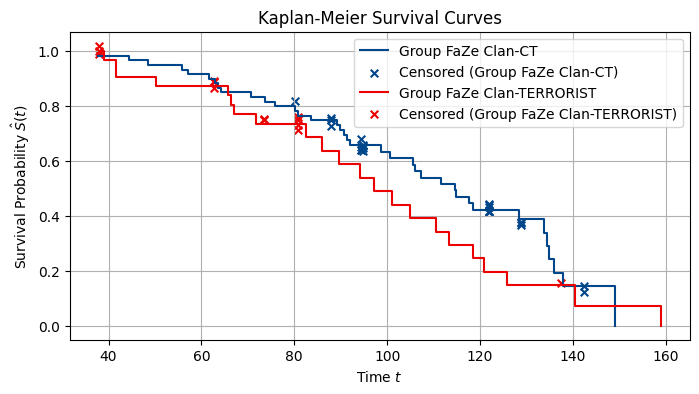

In [231]:
# make FaZe survival data
fz_survival = survival_data[survival_data['user_team_clan_name'] == "FaZe Clan"]

plt.figure(figsize=(8,4))

# add jitter to points to distinguish between multiple censors at one time
jitter_strength = 0.025

for i, group in enumerate(fz_survival['team_side_identifier'].unique()):
    # Filter data for the group
    group_data = fz_survival[fz_survival['team_side_identifier'] == group]
    
    # Compute Kaplan-Meier estimator
    time, survival_prob, conf_int = kaplan_meier_estimator(
        group_data['died'], 
        group_data['seconds'],
        conf_type="log-log"
    )
    
    # Plot the survival curve
    plt.step(time, survival_prob, where="post", label=f"Group {group}", color = lancet_palette[i % len(lancet_palette)])

    # Add censored points
    censored_times = group_data[group_data['died'] == False]['seconds']
    censored_survival = [survival_prob[np.searchsorted(time, t, side="right") - 1] for t in censored_times]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, len(censored_times))
    plt.scatter(censored_times, censored_survival + jitter, 
                color=lancet_palette[i % len(lancet_palette)], s=30, marker = "x", label=f"Censored (Group {group})")


# Customize the plot
plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Time $t$")
plt.ylabel("Survival Probability $\hat{S}(t)$")
plt.legend()
plt.grid(True)
plt.show()